# Задание 1: Эксперименты с глубиной сети

## 1.1. Сравнение моделей разной глубины

### Импорт библиотек

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms.v2 as v2
import matplotlib.pyplot as plt
import time
import numpy as np
from torch.utils.data import DataLoader
import os

### Подготовка данных

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 64
num_epochs = 15
lr = 0.001

transform = v2.Compose([
    v2.ToTensor(),
    v2.Normalize((0.1307,), (0.3081,))
])

train_dataset = torchvision.datasets.MNIST(
    root='./data', train=True, download=False, transform=transform)
test_dataset = torchvision.datasets.MNIST(
    root='./data', train=False, download=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

C:\miniconda\envs\ml\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


### Создание моделей

In [5]:
class LinearClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(28*28, 10)
    
    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.fc(x)

class TwoLayerNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(28*28, 128)
        self.layer2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.relu(self.layer1(x))
        return self.layer2(x)

class ThreeLayerNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(28*28, 256)
        self.layer2 = nn.Linear(256, 128)
        self.layer3 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        return self.layer3(x)

class FiveLayerNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(28*28, 512)
        self.layer2 = nn.Linear(512, 256)
        self.layer3 = nn.Linear(256, 128)
        self.layer4 = nn.Linear(128, 64)
        self.layer5 = nn.Linear(64, 10)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.relu(self.layer3(x))
        x = self.relu(self.layer4(x))
        return self.layer5(x)

class SevenLayerNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(28*28, 512)
        self.layer2 = nn.Linear(512, 512)
        self.layer3 = nn.Linear(512, 256)
        self.layer4 = nn.Linear(256, 256)
        self.layer5 = nn.Linear(256, 128)
        self.layer6 = nn.Linear(128, 64)
        self.layer7 = nn.Linear(64, 10)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.relu(self.layer3(x))
        x = self.relu(self.layer4(x))
        x = self.relu(self.layer5(x))
        x = self.relu(self.layer6(x))
        return self.layer7(x)

### Создание функций обучения и визуализации

In [23]:
def train_evaluate_model(model, train_loader, test_loader, num_epochs, lr):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    start_time = time.time()
    
    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            y_pred = model(images)
            loss = criterion(y_pred, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = y_pred.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        
        train_loss = running_loss / len(train_loader)
        train_acc = 100. * correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        
        model.eval()
        running_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                y_pred = model(images)
                loss = criterion(y_pred, labels)
                
                running_loss += loss.item()
                _, predicted = y_pred.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
        
        val_loss = running_loss / len(test_loader)
        val_acc = 100. * correct / total
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        print(f'Epoch [{epoch+1}/{num_epochs}] | '
              f'Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f} | '
              f'Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%')
    
    training_time = time.time() - start_time
    return train_losses, val_losses, train_accs, val_accs, training_time

def visualize_results(results, save_dir='plots', show=True):
    """
    Визуализирует результаты обучения и сохраняет графики в указанную папку.
    """
    
    # Для красоты
    available_styles = plt.style.available
    preferred_styles = ['seaborn', 'ggplot', 'bmh', 'classic']
    selected_style = None
    
    for style in preferred_styles:
        if style in available_styles:
            selected_style = style
            break
    
    if selected_style:
        plt.style.use(selected_style)
    else:
        print("Ни один из стилей не работает. Используем стандартный.")
    
    # Графики точности
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    for name, res in results.items():
        plt.plot(res['train_acc'], '--', label=f'{name} (train)')
    plt.title('Тренировочные Accuracy')
    plt.xlabel('Эпоха')
    plt.ylabel('Accuracy (%)')
    plt.grid(True)
    plt.legend()
    
    plt.subplot(1, 2, 2)
    for name, res in results.items():
        plt.plot(res['val_acc'], '-', label=f'{name} (test)')
    plt.title('Валидационные Accuracy')
    plt.xlabel('Эпоха')
    plt.ylabel('Accuracy (%)')
    plt.grid(True)
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'accuracy_comparison.png'), dpi=300)
    if show:
        plt.show()
    plt.close()
    
    # Графики функции потерь
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    for name, res in results.items():
        plt.plot(res['train_loss'], '--', label=f'{name} (train)')
    plt.title('Train loss')
    plt.xlabel('Эпоха')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()
    
    plt.subplot(1, 2, 2)
    for name, res in results.items():
        plt.plot(res['val_loss'], '-', label=f'{name} (test)')
    plt.title('Val Loss')
    plt.xlabel('Эпоха')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'loss_comparison.png'), dpi=300)
    if show:
        plt.show()
    plt.close()
    
    # Графики сравнения времени обучения
    models = list(results.keys())
    times = [res['time'] for res in results.values()]
    
    plt.figure(figsize=(8, 5))
    bars = plt.bar(models, times, color='skyblue')
    plt.title('Время обучения')
    plt.xlabel('Модель')
    plt.ylabel('Время (сек)')
    plt.grid(axis='y')
    
    # Добавляем значения на столбцы
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.1f}',
                 ha='center', va='bottom')
    
    plt.savefig(os.path.join(save_dir, 'train_time.png'), dpi=300)
    if show:
        plt.show()
    plt.close()
    
    final_train_acc = [res['train_acc'][-1] for res in results.values()]
    final_val_acc = [res['val_acc'][-1] for res in results.values()]
    
    x = np.arange(len(models))
    width = 0.35
    
    plt.figure(figsize=(10, 5))
    plt.bar(x - width/2, final_train_acc, width, label='Train Accuracy')
    plt.bar(x + width/2, final_val_acc, width, label='Val Accuracy')
    
    plt.title('Финальные значения Accuracy')
    plt.xlabel('Модель')
    plt.ylabel('Accuracy (%)')
    plt.xticks(x, models)
    plt.legend()
    plt.grid(True)
    
    # Добавляем значения на столбцы
    for i in range(len(models)):
        plt.text(x[i] - width/2, final_train_acc[i] + 0.5,
                 f'{final_train_acc[i]:.1f}',
                 ha='center')
        plt.text(x[i] + width/2, final_val_acc[i] + 0.5,
                 f'{final_val_acc[i]:.1f}',
                 ha='center')
    
    plt.savefig(os.path.join(save_dir, 'final_accuracy.png'), dpi=300)
    if show:
        plt.show()
    plt.close()

### Обучение моделей

In [24]:
models = {
    "1 слой": LinearClassifier(),
    "2 слоя": TwoLayerNet(),
    "3 слоя": ThreeLayerNet(),
    "5 слоёв": FiveLayerNet(),
    "7 слоёв": SevenLayerNet()
}

results = {}
for name, model in models.items():
    print(f"\=== Тренировка модели {name} ===")
    result = train_evaluate_model(
        model, train_loader, test_loader, num_epochs, lr
    )
    results[name] = {
        "train_loss": result[0],
        "val_loss": result[1],
        "train_acc": result[2],
        "val_acc": result[3],
        "time": result[4]
    }

<>:11: SyntaxWarning: invalid escape sequence '\='
<>:11: SyntaxWarning: invalid escape sequence '\='
C:\Users\Михаил\AppData\Local\Temp\ipykernel_11732\2680713008.py:11: SyntaxWarning: invalid escape sequence '\='
  print(f"\=== Тренировка модели {name} ===")


\=== Тренировка модели 1 слой ===
Epoch [1/15] | Train Loss: 0.3971, Val Loss: 0.2947 | Train Acc: 88.69%, Val Acc: 91.58%
Epoch [2/15] | Train Loss: 0.2940, Val Loss: 0.2788 | Train Acc: 91.65%, Val Acc: 92.10%
Epoch [3/15] | Train Loss: 0.2824, Val Loss: 0.2739 | Train Acc: 92.11%, Val Acc: 92.32%
Epoch [4/15] | Train Loss: 0.2751, Val Loss: 0.2800 | Train Acc: 92.34%, Val Acc: 91.98%
Epoch [5/15] | Train Loss: 0.2703, Val Loss: 0.2722 | Train Acc: 92.42%, Val Acc: 92.47%
Epoch [6/15] | Train Loss: 0.2681, Val Loss: 0.2791 | Train Acc: 92.54%, Val Acc: 92.11%
Epoch [7/15] | Train Loss: 0.2648, Val Loss: 0.2701 | Train Acc: 92.61%, Val Acc: 92.49%
Epoch [8/15] | Train Loss: 0.2626, Val Loss: 0.2758 | Train Acc: 92.67%, Val Acc: 92.34%
Epoch [9/15] | Train Loss: 0.2606, Val Loss: 0.2870 | Train Acc: 92.73%, Val Acc: 92.24%
Epoch [10/15] | Train Loss: 0.2608, Val Loss: 0.2832 | Train Acc: 92.71%, Val Acc: 92.28%
Epoch [11/15] | Train Loss: 0.2578, Val Loss: 0.2787 | Train Acc: 92.82%, V

### Визуализация кривых обучения

In [29]:
visualize_results(results, show=False)

### Вывод

NN с 1 слоем обучилась хуже, чем все остальные NN, если судить по метрике accuracy. 

Все остальные NN несильно отличались друг друга (метрики accuracy у них практически равны между собой). Но если судить по функции потерь на валидации (val_loss), лучше всех себя проявила NN с 3 слоями, 7 эпоха (если бы сделали early stopping) - Train Loss: 0.0265, Val Loss: 0.0715.

## 1.2. Анализ переобучения

### Подготовка данных

In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

# Общие параметры
batch_size = 128
num_epochs = 10
lr = 0.001

# Берём трансформер из предыдущего задания для MNIST
mnist_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])


cifar_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

mnist_train = torchvision.datasets.MNIST(root='./data', train=True, download=False, transform=mnist_transform)
mnist_test = torchvision.datasets.MNIST(root='./data', train=False, download=False, transform=mnist_transform)

cifar_train = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=cifar_transform)
cifar_test = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=cifar_transform)

mnist_train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
mnist_test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False)

cifar_train_loader = torch.utils.data.DataLoader(cifar_train, batch_size=batch_size, shuffle=True)
cifar_test_loader = torch.utils.data.DataLoader(cifar_test, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


### Модель NN

In [37]:
class BaseModel(nn.Module):
    def __init__(self, layers, input_size, num_classes, use_bn=False, use_dropout=False):
        super().__init__()
        self.layers = nn.ModuleList()
        in_features = input_size
        
        for i, out_features in enumerate(layers):
            self.layers.append(nn.Linear(in_features, out_features))
            
            if i < len(layers) - 1:  # Проверка на последний слой
                if use_bn:
                    self.layers.append(nn.BatchNorm1d(out_features))
                
                self.layers.append(nn.ReLU())
                
                if use_dropout:
                    self.layers.append(nn.Dropout(0.5))
            
            in_features = out_features
        
        self.layers.append(nn.Linear(in_features, num_classes))
    
    def forward(self, x):
        x = x.view(x.size(0), -1)
        for layer in self.layers:
            x = layer(x)
        return x

# Конфигурации для создания разных NN
model_configs = {
    "1 слой": [10],
    "2 слоя": [128, 10],
    "3 слоя": [256, 128, 10],
    "5 слоёв": [512, 256, 128, 64, 10],
    "7 слоёв": [512, 512, 256, 256, 128, 64, 10]
}

### Обучение моделей NN

#### Без регуляризацией

In [38]:
datasets = {
    "MNIST": (mnist_train_loader, mnist_test_loader, 28*28, 10),
    "CIFAR-10": (cifar_train_loader, cifar_test_loader, 3*32*32, 10)
}

results = {}

for dataset_name, (train_loader, test_loader, input_size, num_classes) in datasets.items():
    print(f"\n\\ Датасет: {dataset_name} \\")
    
    dataset_results = {}
    for model_name, layers in model_configs.items():
        print(f"\nТренировка модели {model_name} на датасете {dataset_name}")
        model = BaseModel(layers, input_size, num_classes)
        train_res = train_evaluate_model(model, train_loader, test_loader, num_epochs, lr)
        res = {
            "train_loss": train_res[0],
            "val_loss": train_res[1],
            "train_acc": train_res[2],
            "val_acc": train_res[3],
            "time": train_res[4]
        }
        dataset_results[model_name] = res
    
    results[dataset_name] = dataset_results


\ Датасет: MNIST \

Тренировка модели 1 слой на датасете MNIST
Epoch [1/10] | Train Loss: 0.5431, Val Loss: 0.3054 | Train Acc: 84.93%, Val Acc: 91.37%
Epoch [2/10] | Train Loss: 0.3044, Val Loss: 0.2851 | Train Acc: 91.31%, Val Acc: 91.84%
Epoch [3/10] | Train Loss: 0.2861, Val Loss: 0.2711 | Train Acc: 91.86%, Val Acc: 92.39%
Epoch [4/10] | Train Loss: 0.2777, Val Loss: 0.2704 | Train Acc: 92.15%, Val Acc: 92.14%
Epoch [5/10] | Train Loss: 0.2716, Val Loss: 0.2687 | Train Acc: 92.39%, Val Acc: 92.66%
Epoch [6/10] | Train Loss: 0.2680, Val Loss: 0.2696 | Train Acc: 92.50%, Val Acc: 92.30%
Epoch [7/10] | Train Loss: 0.2650, Val Loss: 0.2694 | Train Acc: 92.52%, Val Acc: 92.27%
Epoch [8/10] | Train Loss: 0.2624, Val Loss: 0.2689 | Train Acc: 92.64%, Val Acc: 92.33%
Epoch [9/10] | Train Loss: 0.2609, Val Loss: 0.2683 | Train Acc: 92.72%, Val Acc: 92.70%
Epoch [10/10] | Train Loss: 0.2593, Val Loss: 0.2653 | Train Acc: 92.78%, Val Acc: 92.53%

Тренировка модели 2 слоя на датасете MNIST
E

#### С регуляризацией

In [39]:
reg_results = {}
for dataset_name, (train_loader, test_loader, input_size, num_classes) in datasets.items():
    print(f"\n\\ Датасет: {dataset_name} \\")

    dataset_reg_results = {}
    for model_name, layers in model_configs.items():
        if len(layers) > 2:  # Для моделей с 3+ слоями
            print(f"\nТренировка с регуляризацией {model_name} на {dataset_name}")
            model = BaseModel(layers, input_size, num_classes, use_bn=True, use_dropout=True)
            train_res = train_evaluate_model(model, train_loader, test_loader, num_epochs, lr)
            res = {
                "train_loss": train_res[0],
                "val_loss": train_res[1],
                "train_acc": train_res[2],
                "val_acc": train_res[3],
                "time": train_res[4]
            }
            dataset_reg_results[f"{model_name}_reg"] = res
    
    reg_results[dataset_name] = dataset_reg_results


\ Датасет: MNIST \

Тренировка с регуляризацией 3 слоя на MNIST
Epoch [1/10] | Train Loss: 0.4971, Val Loss: 0.1595 | Train Acc: 86.79%, Val Acc: 95.03%
Epoch [2/10] | Train Loss: 0.2477, Val Loss: 0.1142 | Train Acc: 92.76%, Val Acc: 96.40%
Epoch [3/10] | Train Loss: 0.1981, Val Loss: 0.0997 | Train Acc: 94.08%, Val Acc: 96.97%
Epoch [4/10] | Train Loss: 0.1735, Val Loss: 0.0891 | Train Acc: 94.76%, Val Acc: 97.28%
Epoch [5/10] | Train Loss: 0.1590, Val Loss: 0.0794 | Train Acc: 95.20%, Val Acc: 97.50%
Epoch [6/10] | Train Loss: 0.1429, Val Loss: 0.0792 | Train Acc: 95.77%, Val Acc: 97.71%
Epoch [7/10] | Train Loss: 0.1354, Val Loss: 0.0737 | Train Acc: 95.91%, Val Acc: 97.85%
Epoch [8/10] | Train Loss: 0.1281, Val Loss: 0.0743 | Train Acc: 96.04%, Val Acc: 97.66%
Epoch [9/10] | Train Loss: 0.1213, Val Loss: 0.0700 | Train Acc: 96.30%, Val Acc: 97.95%
Epoch [10/10] | Train Loss: 0.1139, Val Loss: 0.0702 | Train Acc: 96.56%, Val Acc: 97.98%

Тренировка с регуляризацией 5 слоёв на MNIS

### Визуализация Accuracy

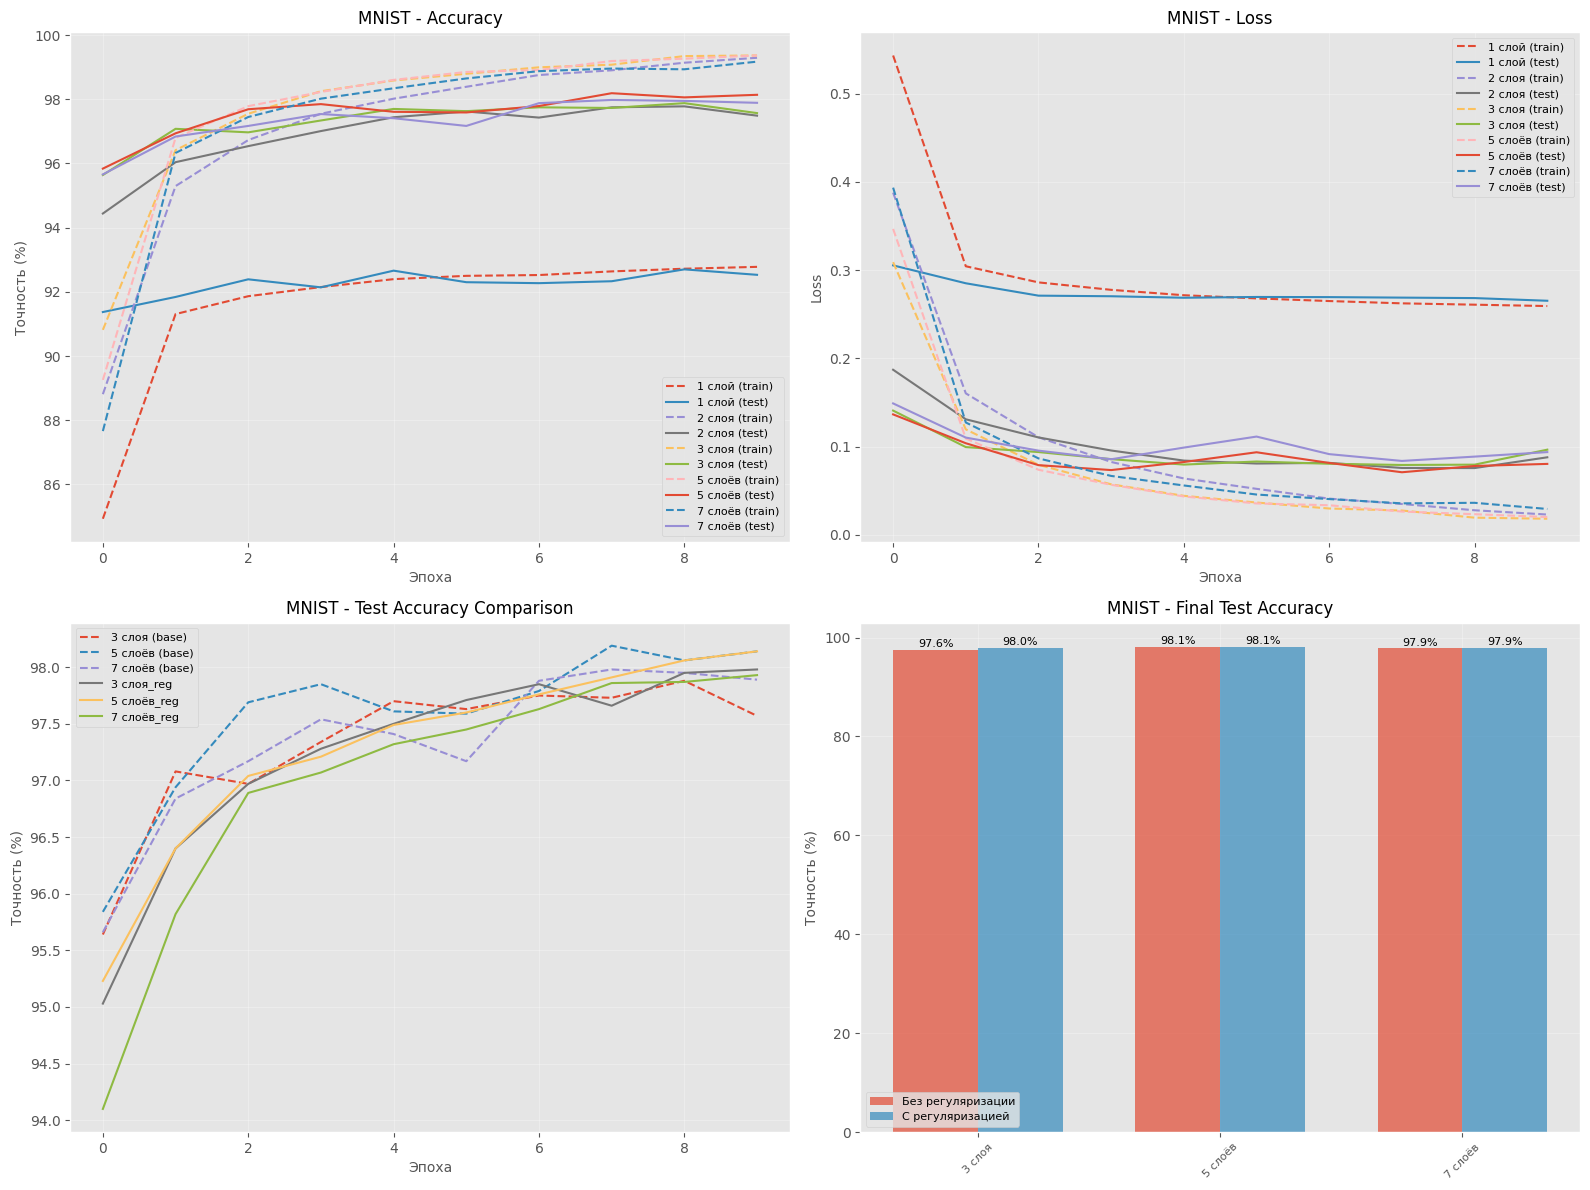

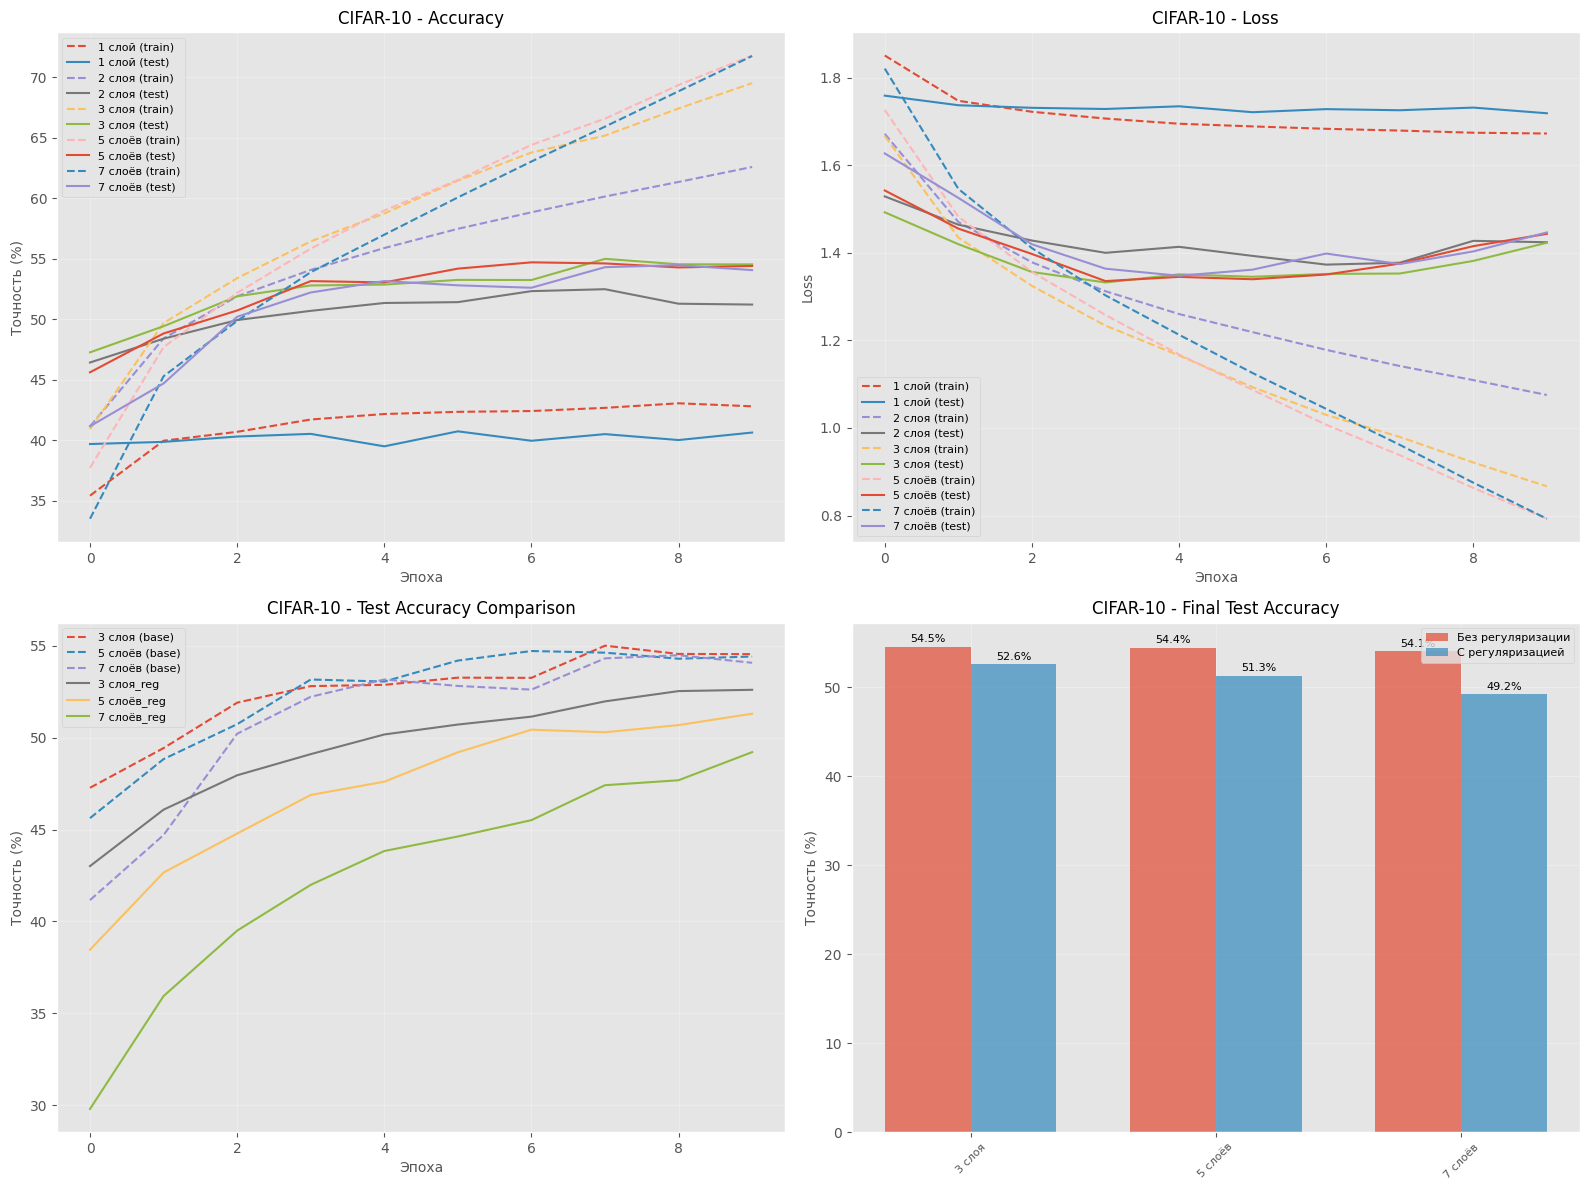

In [53]:
def plot_results(dataset_name, results, reg_results=None):
    """Функция визуализации результатов обучения"""
    
    # Создаем папку для сохранения графиков
    os.makedirs('plots', exist_ok=True)
    
    # Создаем фигуру
    plt.figure(figsize=(16, 12))
    
    # 1. Графики точности (accuracy)
    plt.subplot(2, 2, 1)
    for model_name, res in results.items():
        plt.plot(res['train_acc'], '--', label=f'{model_name} (train)')
        plt.plot(res['val_acc'], '-', label=f'{model_name} (test)')
    plt.title(f'{dataset_name} - Accuracy', fontsize=12)
    plt.xlabel('Эпоха', fontsize=10)
    plt.ylabel('Точность (%)', fontsize=10)
    plt.legend(fontsize=8)
    plt.grid(True, alpha=0.3)
    
    # 2. Графики потерь (loss)
    plt.subplot(2, 2, 2)
    for model_name, res in results.items():
        plt.plot(res['train_loss'], '--', label=f'{model_name} (train)')
        plt.plot(res['val_loss'], '-', label=f'{model_name} (test)')
    plt.title(f'{dataset_name} - Loss', fontsize=12)
    plt.xlabel('Эпоха', fontsize=10)
    plt.ylabel('Loss', fontsize=10)
    plt.legend(fontsize=8)
    plt.grid(True, alpha=0.3)
    
    # 3. Сравнение точности с регуляризацией (если есть)
    if reg_results:
        # Получаем список моделей с регуляризацией
        reg_model_names = list(reg_results.keys())
        base_model_names = [name.replace('_reg', '') for name in reg_model_names]
        
        plt.subplot(2, 2, 3)
        # Базовые модели
        for model_name in base_model_names:
            if model_name in results:
                plt.plot(results[model_name]['val_acc'], '--', label=f'{model_name} (base)')
        # Регуляризованные модели
        for model_name, res in reg_results.items():
            plt.plot(res['val_acc'], '-', label=f'{model_name}')
        plt.title(f'{dataset_name} - Test Accuracy Comparison', fontsize=12)
        plt.xlabel('Эпоха', fontsize=10)
        plt.ylabel('Точность (%)', fontsize=10)
        plt.legend(fontsize=8)
        plt.grid(True, alpha=0.3)
        
        # 4. Сравнение финальной точности
        plt.subplot(2, 2, 4)
        
        # Подготавливаем данные
        base_acc = []
        reg_acc = []
        labels = []
        
        for model_name in base_model_names:
            if model_name in results:
                base_acc.append(results[model_name]['val_acc'][-1])
                labels.append(model_name)
                reg_name = f"{model_name}_reg"
                if reg_name in reg_results:
                    reg_acc.append(reg_results[reg_name]['val_acc'][-1])
        
        # Настройки для столбцов
        x = np.arange(len(labels))
        width = 0.35
        
        # Рисуем столбцы
        plt.bar(x - width/2, base_acc, width, label='Без регуляризации', alpha=0.7)
        plt.bar(x[:len(reg_acc)] + width/2, reg_acc, width, label='С регуляризацией', alpha=0.7)
        
        # Добавляем значения на столбцы
        for i, acc in enumerate(base_acc):
            plt.text(i - width/2, acc + 0.5, f'{acc:.1f}%', ha='center', fontsize=8)
        
        for i, acc in enumerate(reg_acc):
            plt.text(i + width/2, acc + 0.5, f'{acc:.1f}%', ha='center', fontsize=8)
        
        plt.xticks(x, labels, rotation=45, fontsize=8)
        plt.title(f'{dataset_name} - Final Test Accuracy', fontsize=12)
        plt.ylabel('Точность (%)', fontsize=10)
        plt.legend(fontsize=8)
        plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'plots/{dataset_name}_results.png', dpi=300, bbox_inches='tight')
    plt.close()  # Закрываем фигуру для экономии памяти

# Пример вызова функции
for dataset_name in datasets.keys():
    reg_res = reg_results.get(dataset_name, None)
    plot_results(dataset_name, results[dataset_name], reg_res)

### Анализ переобучения

In [65]:
analys_mnist = [
    ['MNIST', 1, 10, 'БезРег', 'Показатели train loss растут, а val_loss не изменяется, что говорит о переобучении'],   
    ['MNIST', 2, 10, 'БезРег', 'Показатели train loss растут, а val_loss падает, что говорит о переобучении'],
    ['MNIST', 3, 4, 'БезРег', 'Показатели train loss растут, а val_loss не изменяется, что говорит о переобучении'],
    ['MNIST', 5, 0, 'БезРег', 'Нет переобучения'],
    ['MNIST', 7, 9, 'БезРег', 'Показатели train loss растут, а val_loss падает, что говорит о переобучении'],
    ['MNIST', 7, 8, 'Рег', 'Показатели train loss растут, а val_loss не изменяется, что говорит о переобучении']
]

analys_cifar = [
    ['CIFAR', 1, 2, 'БезРег', 'Показатели train loss растут, а val_loss не изменяется или уменьшается, что говорит о переобучении'],
    ['CIFAR', 2, 8, 'БезРег', 'Показатели train loss растут, а val_loss не изменяется или уменьшается, что говорит о переобучении'],
    ['CIFAR', 3, 0, 'БезРег', 'Нет переобучения'],
    ['CIFAR', 5, 7, 'БезРег', 'Показатели train loss растут, а val_loss не изменяется или уменьшается, что говорит о переобучении'],
    ['CIFAR', 7, 10, 'БезРег', 'Показатели train loss растут, а val_loss не изменяется или уменьшается, что говорит о переобучении']
]

# Вывод информации:
def get_analys(dataset_name, information):
    print(f'=== Переобучение {dataset_name}: ===\n')
    for data in information:
        print(f"* Название датасета: {data[0]}\n* Кол-во слоёв: {data[1]}\n* Эпоха нач. переобуч.: {data[2]}\n* БезРег/Рег: {data[3]}")
        print(f"* Описание: {data[4]}\n\n")

get_analys("MNIST", analys_mnist)
get_analys("CIFAR", analys_cifar)

=== Переобучение MNIST: ===

* Название датасета: MNIST
* Кол-во слоёв: 1
* Эпоха нач. переобуч.: 10
* БезРег/Рег: БезРег
* Описание: Показатели train loss растут, а val_loss не изменяется, что говорит о переобучении


* Название датасета: MNIST
* Кол-во слоёв: 2
* Эпоха нач. переобуч.: 10
* БезРег/Рег: БезРег
* Описание: Показатели train loss растут, а val_loss падает, что говорит о переобучении


* Название датасета: MNIST
* Кол-во слоёв: 3
* Эпоха нач. переобуч.: 4
* БезРег/Рег: БезРег
* Описание: Показатели train loss растут, а val_loss не изменяется, что говорит о переобучении


* Название датасета: MNIST
* Кол-во слоёв: 5
* Эпоха нач. переобуч.: 0
* БезРег/Рег: БезРег
* Описание: Нет переобучения


* Название датасета: MNIST
* Кол-во слоёв: 7
* Эпоха нач. переобуч.: 9
* БезРег/Рег: БезРег
* Описание: Показатели train loss растут, а val_loss падает, что говорит о переобучении


* Название датасета: MNIST
* Кол-во слоёв: 7
* Эпоха нач. переобуч.: 8
* БезРег/Рег: Рег
* Описание: Пок